In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# GET the data
## Memuat Data
import pandas as pd

dataset = pd.read_csv("Capres2014-1.1.csv", usecols=["Isi_Tweet", "Sentimen"])
dataset

,Isi_Tweet,Sentimen
0,"Biusnya habis ! RT""@eddies_song: Dahlan Iskan ...",-1
1,"Presiden Prabowo ,Presiden Terakhir Indonesia",1
2,@republikaonline masa capres prabowo bergitu b...,-1
3,"Kalo kata bapak capres ARB, kita harus ""berani...",1
4,"RT @DhafaRizky_: Najis,org gila doang yg dukun...",-1
...,...,...
1880,Jangan kabur dari tanggung jawab dengan kemasa...,1
1881,@echo_hadiwibowo mana berani pmrntah..m G da y...,1
1882,@IndonesiaCapres ANAK MEDAN DUKUNG CAPRES JK D...,1
1883,"RT @idoidonajib: Jelek! ""@fallenokta: Apa komp...",1


In [3]:
## Mengecek Imbalanced Data
dataset['Sentimen'].value_counts()

Sentimen
 1    1117
-1     768
Name: count, dtype: int64

In [4]:
## Mengganti {-1,1} menjadi {0,1}
dataset['Sentimen'] = dataset['Sentimen'].replace(-1,0)
dataset.head()

,Isi_Tweet,Sentimen
0,"Biusnya habis ! RT""@eddies_song: Dahlan Iskan ...",0
1,"Presiden Prabowo ,Presiden Terakhir Indonesia",1
2,@republikaonline masa capres prabowo bergitu b...,0
3,"Kalo kata bapak capres ARB, kita harus ""berani...",1
4,"RT @DhafaRizky_: Najis,org gila doang yg dukun...",0


In [5]:
dataset['Sentimen'].value_counts()

Sentimen
1    1117
0     768
Name: count, dtype: int64

In [6]:
dataset.drop_duplicates(inplace=True)
dataset

,Isi_Tweet,Sentimen
0,"Biusnya habis ! RT""@eddies_song: Dahlan Iskan ...",0
1,"Presiden Prabowo ,Presiden Terakhir Indonesia",1
2,@republikaonline masa capres prabowo bergitu b...,0
3,"Kalo kata bapak capres ARB, kita harus ""berani...",1
4,"RT @DhafaRizky_: Najis,org gila doang yg dukun...",0
...,...,...
1880,Jangan kabur dari tanggung jawab dengan kemasa...,1
1881,@echo_hadiwibowo mana berani pmrntah..m G da y...,1
1882,@IndonesiaCapres ANAK MEDAN DUKUNG CAPRES JK D...,1
1883,"RT @idoidonajib: Jelek! ""@fallenokta: Apa komp...",1


In [7]:
# MODEL the data
## Pra Pengolahan - Cleaning
import numpy as np
import re
import string

def clean_text(tweet):
    
    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub(r"\d+", "", tweet)
    tweet = re.sub("\\W"," ",tweet) 
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('\,', ' ', tweet)
    tweet = re.sub('\)', ' ', tweet)
    tweet = re.sub('\:', ' ', tweet)
    tweet = re.sub('\-', ' ', tweet)
    tweet = re.sub('\!', ' ', tweet)
    tweet = re.sub('\"', ' ', tweet)
    tweet = re.sub('\.', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    
    return tweet

dataset["Isi_Tweet"] = dataset['Isi_Tweet'].map(lambda x: clean_text(x))
# Convert the titles to lowercase
dataset["Isi_Tweet"] = dataset["Isi_Tweet"].map(lambda x: x.lower())
dataset = dataset[dataset['Isi_Tweet'].apply(lambda x: len(x.split()) >=1)]
dataset.shape

(1596, 2)

In [8]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def wordopt(text):
    text = re.sub(' tersebut ', '', text)
    text = re.sub(' gak ', ' tidak ', text)
    text = re.sub(' tdk ', ' tidak ', text)
    text = re.sub(' tak ', ' tidak ', text)
    text = re.sub(' ga ', ' tidak ', text)
    text = re.sub(' gk ', ' tidak ', text)
    text = re.sub(' tidak ', ' ', text)
    text = re.sub('yg ', 'yang ', text)
    text = re.sub(' yang ', ' ', text)
    text = re.sub(' tp ', ' tapi ', text)
    text = re.sub(' jdi ', ' jadi ', text)
    text = re.sub(' jd ', ' jadi ', text)
    text = re.sub(' jadi ', ' ', text)
    text = re.sub(' org ', ' orang ', text)
    text = re.sub(' hehe ', ' ', text)
    text = re.sub(' hehehe ', ' ', text)
    text = re.sub(' wakakak ', ' ', text)
    text = re.sub(' jls ', ' jelas ', text)
    text = re.sub(' sdh ', ' sudah ', text)
    text = re.sub(' trus ', ' terus ', text)
    text = re.sub(' utk ', ' untuk ', text)
    text = re.sub(' wapres ', ' cawapres ', text)
    text = re.sub(' utk ', ' untuk ', text)
    text = re.sub(' sy ', ' saya ', text)
    text = re.sub(' aku ', ' saya ', text)
    text = re.sub(' gue ', ' saya ', text)
    text = re.sub(' blm ', ' belum ', text)
    text = re.sub('klo ', ' kalau ', text)
    text = re.sub('kalo ', ' kalau ', text)
    text = re.sub(' kalau ', ' ', text)
    text = re.sub(' calon presiden ', ' capres ', text)
    text = re.sub(' mega ', ' megawati ', text)
    text = re.sub(' jkt ', ' jakarta ', text)
    text = re.sub(' deh ', ' ', text)
    text = re.sub('2013', ' ', text)
    text = re.sub(' rt ', ' ', text)
    text = re.sub(' wakilnya ', ' wakil ', text)
    text = re.sub(' lg ', ' ', text)
    text = re.sub(' gt ', ' ', text)
    text = re.sub(' ahhh ', ' ', text)
    text = re.sub(' cm ', ' ', text)
    text = re.sub(' dr ', ' ', text)
    text = re.sub(' kan ', ' ', text)
    text = re.sub(' akn ', ' akan ', text)
    text = re.sub(' nih ', ' ', text)
    text = re.sub(' jg ', ' juga ', text)
    text = re.sub(' cawapresnya ', ' cawapres ', text)
    text = re.sub(' pak ', ' ', text)
    text = re.sub(' followradiopepatah ',' ',text)
    text = re.sub(' d ', ' ', text)
    text = re.sub(' p ', ' ', text)
    text = re.sub('rt ', ' ', text)
    text = re.sub(' bu ', ' ', text)
    text = re.sub(' b ', ' ', text)
    text = re.sub(' jgn ', ' jangan ', text)
    text = re.sub(' sbg ', ' sebagai ', text)
    text = re.sub(' pd ', ' pada ', text)
    text = re.sub(' pa ', ' ', text)
    text = re.sub(' pas ', ' ', text)
    text = re.sub(' b ', ' ', text)
    text = re.sub(' kok ', ' ', text)
    text = re.sub(' om ', ' paman ', text)
    text = re.sub(' gub ', ' gubernur ', text)
    text = re.sub(' aja ', ' saja ', text)
    text = re.sub(' joko widodo ', ' jokowi ', text)
    text = re.sub('tuit', 'tweet', text)
    text = re.sub(' nya ', ' ', text)
    text = re.sub(' jusuf kalla ', ' jk ', text)
    text = re.sub(' dong ', ' ', text)
    text = re.sub(' cuma ', ' hanya ', text)
    text = re.sub(' dgn ', ' dengan ', text)
    text = re.sub(' dg ', ' dengan ', text)
    text = re.sub(' dong ', ' ', text)
    text = re.sub(' hayoo ', ' ', text)
    text = re.sub(' mau ', ' ingin ', text)
    text = re.sub(' ndak ', ' tidak ', text)
    text = re.sub(' pikir ', ' berpikir ', text)

    return text

dataset["Isi_Tweet"] = dataset["Isi_Tweet"].apply(wordopt)
dataset["Isi_Tweet"] = dataset["Isi_Tweet"].apply(stopword.remove)
dataset.shape

(1596, 2)

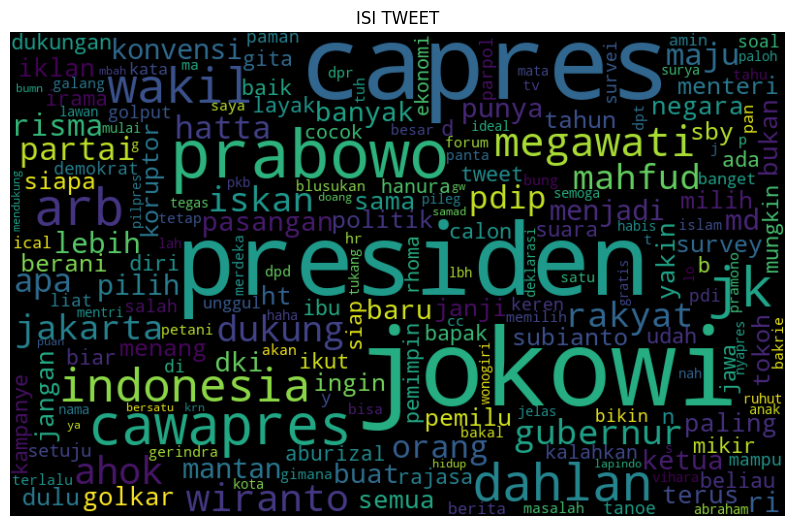

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_word = ' '.join(dataset["Isi_Tweet"])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_word)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("ISI TWEET")
plt.show()

In [11]:
## Pra Pengolahan - Splitting
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(dataset['Isi_Tweet'], dataset['Sentimen'], test_size=0.2,random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5,random_state=42)

In [12]:
train_labels.value_counts()

Sentimen
1    767
0    509
Name: count, dtype: int64

In [13]:
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
import IPython
import keras_tuner as kt

bert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128, 
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask

def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    
    return [np.asarray(tokenID, dtype=np.int32).reshape(-1, 128), 
            np.asarray(input_mask, dtype=np.int32).reshape(-1,128)]

bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", trainable=False)
def bert(hp):
    
    #Input layer
    input_token = keras.layers.Input(shape=(128,), dtype=np.int32,
                                    name="input_token")
    input_mask = keras.layers.Input(shape=(128,), dtype=np.int32,
                                   name="input_mask")

    #Embedding
    bert_embedding = bert_model([input_token, input_mask])[0]
    
    #Hidden layer
    hidden=keras.models.Sequential()
    n_layers_LSTM=hp.Int("n_layers_LSTM", min_value=1, max_value=3, step=1)
    for i in range(n_layers_LSTM):
        n_neurons_LSTM = hp.Int(f"n_neurons_LSTM_{i}", min_value=8, max_value=128, step=8)
        if i != n_layers_LSTM-1:
            return_seq=True
        else:
            return_seq=False
        hidden.add(keras.layers.Bidirectional(keras.layers.LSTM(n_neurons_LSTM,return_sequences=return_seq)))
    LSTM=hidden(bert_embedding)
    
    #Output layer
    output = keras.layers.Dense(1, activation='sigmoid')(LSTM)
    
    model = keras.models.Model(inputs=[input_token, input_mask], outputs=output)
    
    opt=keras.optimizers.Adam(
        learning_rate=hp.Float('lr',1e-3,1e-1,sampling='log'),
        decay=hp.Float('decay',1e-3,1e-1,sampling='log')
    )
    model.compile(optimizer = opt,
                  loss ='binary_crossentropy',
                  metrics=['accuracy'])
   
    return model

class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
from keras_tuner.tuners import BayesianOptimization

bert_train_data = create_input(train_data)
bert_test_data = create_input(test_data)
bert_val_data = create_input(val_data)

tuner = BayesianOptimization(bert,
                             objective = 'val_accuracy', 
                             max_trials = 50,
                             directory = './content/Hasil',
                             project_name = 'Sentiment-BERT',
                             overwrite = True)
tuner.search_space_summary()

Search space summary
Default search space size: 4
n_layers_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
n_neurons_LSTM_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': 'linear'}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
decay (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [15]:
tuner.search(bert_train_data, train_labels,
             batch_size=16, epochs=50,
             validation_data=(bert_val_data, val_labels),
             callbacks=[early_stop, ClearTrainingOutput()])

# Mendapatkan model terbaik
model = tuner.get_best_models()[0]

Trial 50 Complete [00h 12m 18s]
val_accuracy: 0.7562500238418579

Best val_accuracy So Far: 0.8374999761581421
Total elapsed time: 07h 36m 49s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary(1)

Results summary
Results in ./content/Hasil\Sentiment-BERT
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
n_layers_LSTM: 3
n_neurons_LSTM_0: 48
lr: 0.0019620686138715282
decay: 0.04631328048886263
n_neurons_LSTM_1: 88
n_neurons_LSTM_2: 8
Score: 0.8374999761581421


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  124441344   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

In [19]:
history=model.fit(bert_train_data, train_labels, validation_data=(bert_val_data, val_labels),
                    epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
80/80 [==============================] - 52s 454ms/step - loss: 0.1266 - accuracy: 0.9710 - val_loss: 0.4646 - val_accuracy: 0.8313
Epoch 2/100
80/80 [==============================] - 32s 403ms/step - loss: 0.1165 - accuracy: 0.9734 - val_loss: 0.5040 - val_accuracy: 0.8188
Epoch 3/100
80/80 [==============================] - 32s 406ms/step - loss: 0.1321 - accuracy: 0.9624 - val_loss: 0.5132 - val_accuracy: 0.7937
Epoch 4/100
80/80 [==============================] - 33s 407ms/step - loss: 0.1105 - accuracy: 0.9781 - val_loss: 0.4941 - val_accuracy: 0.8188
Epoch 5/100
80/80 [==============================] - 32s 406ms/step - loss: 0.1140 - accuracy: 0.9710 - val_loss: 0.5148 - val_accuracy: 0.8125
Epoch 6/100
80/80 [==============================] - 33s 408ms/step - loss: 0.1146 - accuracy: 0.9687 - val_loss: 0.4988 - val_accuracy: 0.8125
Epoch 7/100
80/80 [==============================] - 32s 406ms/step - loss: 0.1066 - accuracy: 0.9694 - val_loss: 0.5227 - val_accuracy:

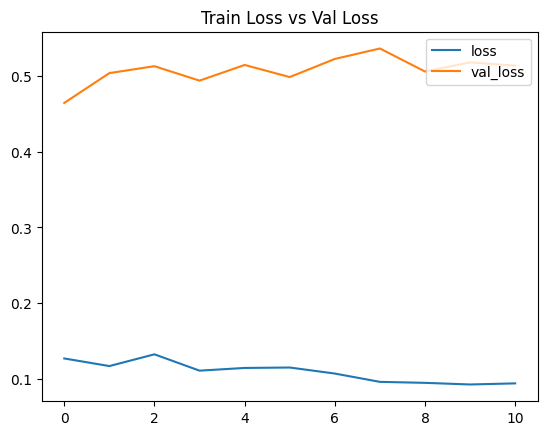

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Train Loss vs Val Loss')
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(bert_test_data, test_labels)
print('Test accuracy:', test_acc)

5/5 [==============================] - 7s 611ms/step - loss: 0.4623 - accuracy: 0.8188
Test accuracy: 0.8187500238418579


In [22]:
model.save('model_mlp_sentiment.h5')